In [1]:
%matplotlib inline


Link Prediction using Graph Neural Networks
===========================================


Overview of Link Prediction with GNN
------------------------------------

Many applications such as social recommendation, item recommendation,
knowledge graph completion, etc., can be formulated as link prediction,
which predicts whether an edge exists between two particular nodes. This
tutorial shows an example of predicting whether a citation relationship,
either citing or being cited, between two papers exists in a citation
network.

This tutorial formulates the link prediction problem as a binary classification
problem as follows:

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training
   set and a test set.
-  Evaluate the model with any binary classification metric such as Area
   Under Curve (AUC).


In some domains such as large-scale recommender systems or information
retrieval, you may favor metrics that emphasize good performance of
top-K predictions. In these cases you may want to consider other metrics
such as mean average precision, and use other negative sampling methods,
which are beyond the scope of this tutorial.


In [1]:
import itertools
import os



os.environ["DGLBACKEND"] = "pytorch"

import time
import copy
import dgl
import dgl.data
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from sklearn.metrics import roc_auc_score

In [2]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Prepare training and testing sets
---------------------------------

This tutorial randomly picks 10% of the edges for positive examples in
the test set, and leave the rest for the training set. It then samples
the same number of edges for negative examples in both sets.




In [3]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy()))) # Adjacency Matrix
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges())

test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

When training, you will need to remove the edges in the test set from
the original graph. You can do this via ``dgl.remove_edges``.

<div class="alert alert-info"><h4>Note</h4><p>``dgl.remove_edges`` works by creating a subgraph from the
   original graph, resulting in a copy and therefore could be slow for
   large graphs. If so, you could save the training and test graph to
   disk, as you would do for preprocessing.</p></div>




In [4]:
train_g = dgl.remove_edges(g, eids[:test_size])

Define a GraphSAGE model
------------------------

This tutorial builds a model consisting of two
`GraphSAGE <https://arxiv.org/abs/1706.02216>`__ layers, each computes
new node representations by averaging neighbor information. DGL provides
``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.




In [5]:
from dgl.nn import SAGEConv


# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

The model then predicts the probability of existence of an edge by
computing a score between the representations of both incident nodes
with a function (e.g. an MLP or a dot product), which you will see in
the next section.

\begin{align}\hat{y}_{u\sim v} = f(h_u, h_v)\end{align}




Positive graph, negative graph, and ``apply_edges``
---------------------------------------------------

In previous tutorials you have learned how to compute node
representations with a GNN. However, link prediction requires you to
compute representation of *pairs of nodes*.

DGL recommends you to treat the pairs of nodes as another graph, since
you can describe a pair of nodes with an edge. In link prediction, you
will have a *positive graph* consisting of all the positive examples as
edges, and a *negative graph* consisting of all the negative examples.
The *positive graph* and the *negative graph* will contain the same set
of nodes as the original graph.  This makes it easier to pass node
features among multiple graphs for computation.  As you will see later,
you can directly feed the node representations computed on the entire
graph to the positive and the negative graphs for computing pair-wise
scores.

The following code constructs the positive graph and the negative graph
for the training set and the test set respectively.




In [6]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())

The benefit of treating the pairs of nodes as a graph is that you can
use the ``DGLGraph.apply_edges`` method, which conveniently computes new
edge features based on the incident nodes’ features and the original
edge features (if applicable).

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.




In [7]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

You can also write your own function if it is complex.
For instance, the following module produces a scalar score on each edge
by concatenating the incident nodes’ features and passing it to an MLP.




In [8]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src["h"], edges.dst["h"]], 1)
        return {"score": self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(self.apply_edges)
            return g.edata["score"]

Training loop
-------------

After you defined the node representation computation and the edge score
computation, you can go ahead and define the overall model, loss
function, and evaluation metric.

The loss function is simply binary cross entropy loss.

\begin{align}\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)\end{align}

The evaluation metric in this tutorial is AUC.




In [9]:
model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
# pred = MLPPredictor(16)
pred = DotPredictor()


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [10]:
def evaluate(test_pos_g, h):
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        test_loss=compute_loss(pos_score, neg_score)
        test_loss=test_loss.detach().item()
        AUC=compute_auc(pos_score, neg_score)
        return test_loss, AUC

In [11]:
def train(model,epoch):   
       
        # forward
        h = model(train_g, train_g.ndata["feat"])
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        trn_loss = compute_loss(pos_score, neg_score)
        test_loss, auc_test=evaluate(test_pos_g, h)
        # backward
        optimizer.zero_grad()
        trn_loss.backward()
        optimizer.step()
        
        return auc_test, h, trn_loss, test_loss
        #if epoch % 5 == 0:
            #print(f"In epoch {epoch}, Training Loss: {trn_loss:.3f},Test Loss:{test_loss:.3f},Test Auc: {auc_test:.3f},")



In [19]:
num_epoch=80
model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
optimizer = torch.optim.Adam(
            itertools.chain(model.parameters(), pred.parameters()), lr=0.01
        )

# ----------- 4. training -------------------------------- #
all_logits = []
best_checkpoint = dict()
Auc_test=[]
Trn_loss=[] 
Test_loss=[]

for i in range(num_epoch):
        auc_test, _, trn_loss, test_loss=train(model,i) 
        Auc_test.append( auc_test)
        Trn_loss.append(trn_loss)
        Test_loss.append(test_loss)
        if i % 5 == 0:
            print(f"In epoch {i},Test Auc: {auc_test:.3f},")

start = time.time()
h = model(train_g, train_g.ndata["feat"])
_,Auc=evaluate(test_pos_g, h)
end = time.time()

t_inference = end-start   

print(f"Time inference: {t_inference},Test Auc: {Auc:.3f},")

In epoch 0,Test Auc: 0.508,
In epoch 5,Test Auc: 0.621,
In epoch 10,Test Auc: 0.683,
In epoch 15,Test Auc: 0.750,
In epoch 20,Test Auc: 0.766,
In epoch 25,Test Auc: 0.772,
In epoch 30,Test Auc: 0.805,
In epoch 35,Test Auc: 0.841,
In epoch 40,Test Auc: 0.862,
In epoch 45,Test Auc: 0.873,
In epoch 50,Test Auc: 0.877,
In epoch 55,Test Auc: 0.877,
In epoch 60,Test Auc: 0.876,
In epoch 65,Test Auc: 0.873,
In epoch 70,Test Auc: 0.868,
In epoch 75,Test Auc: 0.863,


In [26]:
Trn_loss=[tensor.item() for tensor in Trn_loss]

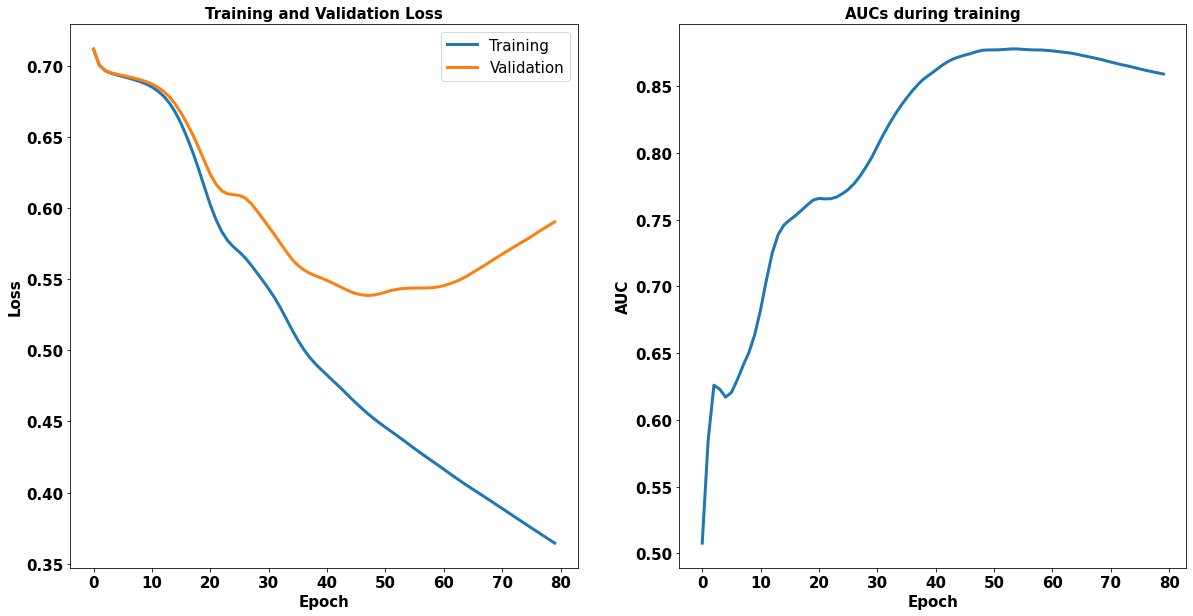

In [34]:

# Plot training and validation accuracy and loss in one figure



plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15})

plt.subplot(1, 2, 1)
plt.plot(Trn_loss,label="Training", linewidth=3)
plt.plot(Test_loss,label="Validation", linewidth=3)
plt.title('Training and Validation Loss',weight='bold', fontsize=15)
plt.xlabel("Epoch",weight='bold', fontsize=15)
plt.ylabel("Loss",weight='bold', fontsize=15)
plt.legend(loc="upper right")
plt.xticks(weight='bold')
plt.yticks(weight='bold')



plt.subplot(1, 2, 2)
plt.plot(Auc_test, linewidth=3)
title = "AUCs during training"
plt.xlabel("Epoch",weight='bold', fontsize=15)
plt.ylabel("AUC",weight='bold', fontsize=15)
#plt.legend(loc="upper right")
plt.title(title, weight='bold', fontsize=15)
plt.xticks(weight='bold')
plt.yticks(weight='bold')

#plt.savefig('Images/Evaluation_SAGE.png')

plt.show()

##  Measurement

In [15]:
import statistics as stat


Eva_final=dict()


Base_model_Auc=[]
T_base_model=[]


In [16]:
num_epoch=80

for i in range(10):
        model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
        optimizer = torch.optim.Adam(
                    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
                )

        # ----------- 4. training -------------------------------- #
        all_logits = []
        best_checkpoint = dict()
        Auc_test=[]
        Trn_loss=[] 
        Test_loss=[]

        for i in range(num_epoch):
                auc_test, _, trn_loss, test_loss=train(model,i) 
                Auc_test.append( auc_test)
                Trn_loss.append(trn_loss)
                Test_loss.append(test_loss)
                if i % 20 == 0:
                    print(f"In epoch {i},Test Auc: {auc_test:.3f},")

        start = time.time()
        h = model(train_g, train_g.ndata["feat"])
        _,Auc=evaluate(test_pos_g, h)
        end = time.time()
        t_inference= end-start
        
        Base_model_Auc.append(Auc)
        T_base_model.append(t_inference)

        print(f"Time inference: {t_inference},Test Auc: {Auc:.3f},")

In epoch 0,Test Auc: 0.523,
In epoch 20,Test Auc: 0.855,
In epoch 40,Test Auc: 0.870,
In epoch 60,Test Auc: 0.880,
Time inference: 0.04036450386047363,Test Auc: 0.870,
In epoch 0,Test Auc: 0.532,
In epoch 20,Test Auc: 0.813,
In epoch 40,Test Auc: 0.881,
In epoch 60,Test Auc: 0.890,
Time inference: 0.030298233032226562,Test Auc: 0.875,
In epoch 0,Test Auc: 0.515,
In epoch 20,Test Auc: 0.836,
In epoch 40,Test Auc: 0.856,
In epoch 60,Test Auc: 0.882,
Time inference: 0.03237032890319824,Test Auc: 0.875,
In epoch 0,Test Auc: 0.526,
In epoch 20,Test Auc: 0.801,
In epoch 40,Test Auc: 0.872,
In epoch 60,Test Auc: 0.885,
Time inference: 0.03030538558959961,Test Auc: 0.861,
In epoch 0,Test Auc: 0.491,
In epoch 20,Test Auc: 0.820,
In epoch 40,Test Auc: 0.872,
In epoch 60,Test Auc: 0.883,
Time inference: 0.030287981033325195,Test Auc: 0.869,
In epoch 0,Test Auc: 0.551,
In epoch 20,Test Auc: 0.821,
In epoch 40,Test Auc: 0.901,
In epoch 60,Test Auc: 0.894,
Time inference: 0.030286312103271484,Test A

In [35]:
Base_model_Auc

[0.8703128860537723,
 0.8750144875452035,
 0.8745904180049865,
 0.8614137148761258,
 0.8693847847083399,
 0.8809227106309382,
 0.8770917095303339,
 0.8815794793468252,
 0.8740711125087037,
 0.8596850924282922]

In [36]:
T_base_model

[0.04036450386047363,
 0.030298233032226562,
 0.03237032890319824,
 0.03030538558959961,
 0.030287981033325195,
 0.030286312103271484,
 0.03032970428466797,
 0.03027033805847168,
 0.03035759925842285,
 0.03023982048034668]

In [26]:
print(f'Base_model_Auc in ten time:')
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(Base_model_Auc[0],Base_model_Auc[1],Base_model_Auc[2],\
        Base_model_Auc[3],Base_model_Auc[4],Base_model_Auc[5],\
        Base_model_Auc[6],Base_model_Auc[7],Base_model_Auc[8],Base_model_Auc[9]))
print ("-"*110)
print(f'Time Inference model in ten time:')
#print(T_base_model)
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(T_base_model[0],T_base_model[1],T_base_model[2],\
        T_base_model[3],T_base_model[4],T_base_model[5],\
        T_base_model[6],T_base_model[7],T_base_model[8],T_base_model[9]))

Base_model_Auc in ten time:
0.8703128860537723|0.8750144875452035|0.8745904180049865|0.8614137148761258|0.8693847847083399|0.8809227106309382|0.8770917095303339|0.8815794793468252|0.8740711125087037|0.8596850924282922  
--------------------------------------------------------------------------------------------------------------
Time Inference model in ten time:
0.04036450386047363|0.030298233032226562|0.03237032890319824|0.03030538558959961|0.030287981033325195|0.030286312103271484|0.03032970428466797|0.03027033805847168|0.03035759925842285|0.03023982048034668 


In [38]:
import statistics as stat

base_model_accuracy_mean = stat.mean(Base_model_Auc)
base_model_accuracy_std =  stat.stdev(Base_model_Auc)
desc_auc = "{:.3f} ± {:.3f}".format(base_model_accuracy_mean,base_model_accuracy_std)
print(f"Auc: {desc_auc}"  )

Eva_final.update({'base model accuracy':float(format(base_model_accuracy_mean, '.4f'))})
                 
t_base_model_mean =stat.mean(T_base_model)
t_base_model_std =stat.stdev(T_base_model)   
desc_T = "{:.3f} ± {:.3f}".format(t_base_model_mean,t_base_model_std)

print(f"Time inference :{desc_T}")
Eva_final.update({'time inference of base model':float(format(t_base_model_mean, '.6f'))})

Auc: 0.872 ± 0.007
Time inference :0.032 ± 0.003


In [32]:
Eva_final

{'base model accuracy': 0.8724, 'time inference of base model': 0.031511}